## Предсказание пола/возраста по посещениям сайтов

Для начала, подключим хранилище s3, содержащее исходные данные:

In [1]:
!chmod 600 .s3_passwd
!mkdir -p mnt
!s3fs hsevkhack mnt -o url=http://hb.vkcs.cloud -o use_path_request_style -o passwd_file=.s3_passwd -o ro

Убедимся, что в директории `mnt` содержатся соответствующие таблицы:

In [2]:
!ls mnt/

geo_dataframe.csv  requests  train_users.csv


Если по каким-то причинам директорию смонтировать не удалось, используйте код ниже, чтобы скачать данные к себе в локальное хранилище. В противном случае **пропустите следующую ячейку**.

In [3]:
import subprocess
!mkdir -p data
!wget https://hsehack.hb.ru-msk.vkcs.cloud/geo_dataframe.csv -P data
!wget https://hsehack.hb.ru-msk.vkcs.cloud/train_users.csv -P data
!mkdir -p data/requests
for i in range(30):
    print(f"Downloading part {i}...")
    subprocess.call(["wget", f"https://hsehack.hb.ru-msk.vkcs.cloud/requests/part_{i}.parquet", "-q", "-P", "data/requests"])

--2024-04-21 12:08:48--  https://hsehack.hb.ru-msk.vkcs.cloud/geo_dataframe.csv
Resolving hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)... 95.163.53.117
Connecting to hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)|95.163.53.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63042 (62K) [text/csv]
Saving to: ‘data/geo_dataframe.csv.6’

geo_dataframe.csv.6 100%[===================>]  61.56K  --.-KB/s    in 0.003s  

2024-04-21 12:08:48 (17.8 MB/s) - ‘data/geo_dataframe.csv.6’ saved [63042/63042]

--2024-04-21 12:08:49--  https://hsehack.hb.ru-msk.vkcs.cloud/train_users.csv
Resolving hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)... 95.163.53.117
Connecting to hsehack.hb.ru-msk.vkcs.cloud (hsehack.hb.ru-msk.vkcs.cloud)|95.163.53.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66826127 (64M) [text/csv]
Saving to: ‘data/train_users.csv.6’

train_users.csv.6   100%[===================>]  63.73M  

## Загружаем данные

Используем Pandas для работы с таблицами. `geo_dataframe` содержит данные о геолокации - регионе и стране.

In [6]:
import pandas as pd
import polars as pl

geo = pd.read_csv('mnt/geo_dataframe.csv')
geo

,geo_id,region_id,country_id
0,1,157,40
1,2,161,40
2,3,265,54
3,4,122,54
4,5,78,40
...,...,...,...
5528,5529,246,54
5529,5530,-1,63
5530,5531,101,40
5531,5532,21,68


Таблица `train_users` - это ваша обучающая выборка, содержащая пол и возраст пользователей. Аналогичная таблица для тестового датасета будет вам предоставлена за час до stop coding.

In [8]:
users = pl.read_csv('mnt/train_users.csv')
users

user_id,gender,age
i64,i64,i64
2,1,61
3,1,55
6,0,46
14,0,66
17,0,53
…,…,…
17588859,1,64
17588860,0,69
17588861,1,51


Для примера - вот распределение пользователей по полу:

<AxesSubplot: xlabel='gender'>

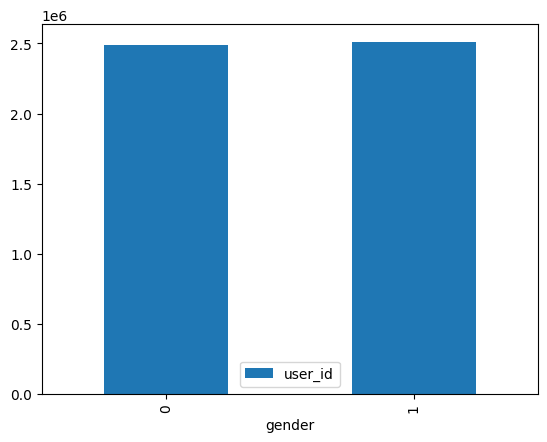

In [4]:
users.groupby('gender').agg({ 'user_id' : len }).plot.bar()

Основные данные о посещениях пользователями сайтов содержатся в табличке `requests`, представленной в формате parquet. Вы можете загрузить только одну часть таблички, или же всю таблицу, если она поместиться в памяти:

In [5]:
req1 = pd.read_parquet('mnt/requests/part_0.parquet')
req1

,timestamp,geo_id,referer,user_id,user_agent
0,1712169477,1224,https://www.domain_1118/path_107938,1628092,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...
1,1711945301,2540,https://domain_3207/path_175610,1013613,Mozilla/5.0 (Linux; Android 8.1.0; Redmi 5 Plu...
2,1712154596,4402,https://domain_2194/path_172150,8274161,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
3,1711941903,3833,https://domain_2042/path_144480,17082498,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
4,1712088484,3866,https://domain_3191/path_9105,12787875,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
...,...,...,...,...,...
10000449,1712161101,702,https://domain_662/path_131980,2062442,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
10000450,1711940706,3515,https://domain_1784/path_45033,2375719,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...
10000451,1712107755,3173,https://domain_1654/path_48166,11781572,Mozilla/5.0 (Linux; arm_64; Android 13; SM-A14...
10000452,1712107427,3833,https://domain_1654/path_10504,15183751,Mozilla/5.0 (Linux; arm_64; Android 12; SM-M21...


## Дерзайте!

Вам необходимо построить предсказательную модель для прогнозирования пола и возраста пользователей по их посещениям. Таблица с тестовыми пользователями будет предоставлена вам за час до stop coding.

ВАЖНО:
* Таблицу с тестовыми данными нельзя использовать для обучения модели. Если жюри увидит, что вы использовали табличку с тестовыми данными - точность модели будет оцениваться в 0 баллов.
* В ходе выступления необходимо продемонстрировать точность модели на тестовых данных.

### Импорт

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier

import datetime
import user_agents
from multiprocessing import Pool

In [6]:
users = pl.read_csv('mnt/train_users.csv')
geo = pd.read_csv('mnt/geo_dataframe.csv')

In [10]:
def define_device_type(**kwargs):
    ua = kwargs['ua']
    if ua.is_tablet:
        return 'tablet'
    if ua.is_mobile:
        return 'mobile'
    if ua.is_touch_capable:
        return 'touch_capable'
    if ua.is_pc:
        return 'PC'
    if ua.is_bot:
        return 'bot'
    if ua.is_email_client:
        return 'email_client'

def define_domain(**kwargs):
    referer = kwargs['referer']
    if not referer:
        return ''
    path_parts = referer.split('/')
    if len(path_parts) < 3:
        return ''
    return path_parts[2]

def define_user_id(**kwargs): return kwargs['user_id']
def define_year(**kwargs): return kwargs['stamp'].year
def define_month(**kwargs): return kwargs['stamp'].month
def define_day(**kwargs): return kwargs['stamp'].day
def define_hour(**kwargs): return kwargs['stamp'].hour
def define_minute(**kwargs): return kwargs['stamp'].minute
def define_second(**kwargs): return kwargs['stamp'].second
def define_weekday(**kwargs): return kwargs['stamp'].weekday()
def define_browser_family(**kwargs): return kwargs['ua'].browser.family
def define_os_family(**kwargs): return kwargs['ua'].os.family
def define_brand(**kwargs): return kwargs['ua'].device.brand
new_features_definition = {
        'user_id': define_user_id,
        'year': define_year,
        'month': define_month,
        'day': define_day,
        'hour': define_hour,
        'minute': define_minute,
        'second': define_second,
        'weekday': define_weekday,
        'browser_family': define_browser_family,
        'os_family': define_os_family,
        'brand': define_brand,
        'device_type': define_device_type,
        'domain': define_domain,
    }

In [48]:
import polars as pl
from collections import Counter
from tqdm import tqdm
# СТАРОЕ
# for i in range(30):
#     print(f'Start process data {i}', end='\t')
#     path = f'mnt/requests/part_{i}.parquet'
#     req = pd.read_parquet(path)
#     train_data = users.merge(req, left_on='user_id', right_on='user_id').merge(geo, left_on='geo_id', right_on='geo_id')
#     train_data['region_id'] = train_data['region_id'].astype('str')
#     train_data['country_id'] = train_data['country_id'].astype('str')
#     train_data['region_id'] = train_data['region_id'] + train_data['country_id']

#     new_features_data = {key: [] for key in new_features_definition}
#     for ind in train_data.index:
#         date = datetime.datetime.fromtimestamp(train_data['timestamp'][ind])
#         ua = user_agents.parse(train_data['user_agent'][ind])
#         referer = train_data['referer'][ind]
#         user_id = train_data['user_id'][ind]
#         for key in new_features_definition:
#             new_features_data[key].append(new_features_definition[key](user_id=user_id, stamp=date, ua=ua, referer=referer))
#     new_features = pd.DataFrame(new_features_data)
#     train_data = train_data.merge(new_features, left_on='user_id', right_on='user_id')
#     train_data.to_parquet(f'featured/part_{i}.parquet')
#     print(f'End process data {i}')

Start process data 0	End process data 0
Start process data 1	End process data 1
Start process data 2	

KeyboardInterrupt: 

In [ ]:
def process_data(args):
    i, users, geo, new_features_definition = args
    path = f'mnt/requests/part_{i}.parquet'
    try:
        req = pd.read_parquet(path)
    except FileNotFoundError:
        return
    print(f'Start process data {i}')
    train_data = users.merge(req, left_on='user_id', right_on='user_id').merge(geo, left_on='geo_id', right_on='geo_id')
    train_data['region_id'] = train_data['region_id'].astype('str')
    train_data['country_id'] = train_data['country_id'].astype('str')
    train_data['region_id'] = train_data['region_id'] + train_data['country_id']

    new_features_data = {key: [] for key in new_features_definition}
    for ind in train_data.index:
        if ind%100000 == 0:
            print(f'Processing {i} on index={ind}')
        date = datetime.datetime.fromtimestamp(train_data['timestamp'][ind])
        ua = user_agents.parse(train_data['user_agent'][ind])
        referer = train_data['referer'][ind]
        user_id = train_data['user_id'][ind]
        for key in new_features_definition:
            feature_value = new_features_definition[key](user_id=user_id, stamp=date, ua=ua, referer=referer)
            new_features_data[key].append(feature_value)
    new_features = pd.DataFrame(new_features_data)
    train_data = train_data.merge(new_features, left_on='user_id', right_on='user_id')
    train_data.to_parquet(f'featured/part_{i}.parquet')
    print(f'End process data {i}')

num_processes = 6
pool = Pool(processes=num_processes)
pool.map(process_data, [(i, users, geo, new_features_definition) for i in range(30)])
pool.close()
pool.join()

Start process data 0
Start process data 2
Start process data 10
Start process data 12
Start process data 14
Start process data 16
Processing 0 on index=0
Processing 2 on index=0
Processing 10 on index=0
Processing 12 on index=0
Processing 16 on index=0
Processing 14 on index=0
Processing 0 on index=100000
Processing 2 on index=100000
Processing 14 on index=100000
Processing 16 on index=100000
Processing 10 on index=100000
Processing 12 on index=100000
Processing 0 on index=200000
Processing 14 on index=200000
Processing 2 on index=200000
Processing 10 on index=200000
Processing 16 on index=200000
Processing 12 on index=200000
Processing 0 on index=300000
Processing 14 on index=300000
Processing 10 on index=300000
Processing 16 on index=300000
Processing 2 on index=300000
Processing 12 on index=300000
Processing 0 on index=400000
Processing 14 on index=400000
Processing 10 on index=400000
Processing 16 on index=400000
Processing 12 on index=400000
Processing 2 on index=400000
Processing

In [9]:
# train_data.to_csv("our_train_data.csv")

In [42]:
# train_data.to_parquet('our_train_data.parquet')

In [75]:
date = datetime.datetime.fromtimestamp(train_data['timestamp'][0])
print(
    date.year,
    date.month,
    date.day,
    date.hour,
    date.minute,
    date.second,
    date.weekday()
)
print(date)
user_agent = parse(train_data['user_agent'][0])
print(
    user_agent.browser.family,
    user_agent.os.family,
    user_agent.device.brand,
    user_agent.device.model,
    user_agent.__dir__()
)
print(user_agent.is_mobile, user_agent.is_tablet, user_agent.is_pc, user_agent.is_bot, user_agent.is_touch_capable)

2024 4 2 0 21 37 1
2024-04-02 00:21:37
Chrome Android Huawei KSA-LX9 ['ua_string', 'os', 'browser', 'device', '__module__', '__init__', '__str__', '__unicode__', '_is_android_tablet', '_is_blackberry_touch_capable_device', 'get_device', 'get_os', 'get_browser', 'is_tablet', 'is_mobile', 'is_touch_capable', 'is_pc', 'is_bot', 'is_email_client', '__dict__', '__weakref__', '__doc__', '__repr__', '__hash__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__new__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']
True False False False True


In [ ]:
user_features = {
    "domain": 3,
    "device_type": 2,
    "brand": 1,
    "hour": 3,
    "weekday": 2
}

user_featured = users.select(["user_id", "gender", "age"])
all_dfs = []

for i in tqdm(range(30)):
    try:
        df = pl.read_parquet(f"featured/part_{i}.parquet")
    except FileNotFoundError:
        continue
    all_dfs.append(df.select(["user_id", "gender", "age", "domain", "device_type", "brand", "hour", "weekday"]))

temp = pl.concat(all_dfs)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(user_featured.drop(["gender", "age"], axis=1), user_featured[["gender", "age"]], train_size=0.8, stratify=user_featured["gender"])

In [24]:
for user_feature in user_features:
    grouped = temp.group_by('user_id').agg(pl.col(user_feature)).to_pandas().to_dict()
    for el in tqdm(grouped['user_id']):
        counts = Counter(list(list(grouped[user_feature][el])))
        grouped_el = sorted(counts, key=lambda x: counts[x], reverse=True)[:user_features[user_feature]]
        if len(grouped[user_feature][el]) < user_features[user_feature]:
            grouped_el += ['NaN'] * (user_features[user_feature] - len(grouped[user_feature][el]))
    grouped['user_id'] = list(grouped['user_id'].values())
    grouped[user_feature] = list(grouped[user_feature].values())
    grouped = pl.DataFrame(grouped).with_columns([f'{user_feature}_top{i}' for i in range(1, user_features[user_feature]+1)])
    user_featured = user_featured.join(grouped, on='user_id')
# for user_feature in user_features:
#     grouped = temp.groupby('user_id').agg(pl.col(user_feature).list()).to_dict()
#     for el in tqdm(grouped):
#         counts = Counter(grouped[el])
#         grouped_el = sorted(counts, key=lambda x: counts[x], reverse=True)[:user_features[user_feature]]
#         if len(grouped[el]) < user_features[user_feature]:
#             grouped_el += [None] * (user_features[user_feature] - len(grouped[el]))
#         grouped[el] = grouped_el
#     columns = [f'{user_feature}_top{i}' for i in range(1, user_features[user_feature]+1)]
#     pre = pl.DataFrame(grouped).with_column_names(columns)
#     user_featured = user_featured.join(pre, on='user_id')


100%|██████████| 4468805/4468805 [00:18<00:00, 237294.89it/s]


ColumnNotFoundError: domain_top1

Error originated just after this operation:
DF ["user_id", "domain"]; PROJECT */2 COLUMNS; SELECTION: "None"

In [26]:
grouped = pl.DataFrame(grouped).with_columns(*[f'{user_feature}_top{i}' for i in range(1, user_features[user_feature]+1)])

ColumnNotFoundError: domain_top1

Error originated just after this operation:
DF ["user_id", "domain"]; PROJECT */2 COLUMNS; SELECTION: "None"

In [20]:
user_featured

user_id,gender,age,domain
i64,i64,i64,list[str]
2,1,61,"[""domain_1654""]"
3,1,55,"[""domain_2867"", ""www.domain_78"", … ""www.domain_78""]"
6,0,46,"[""domain_3194"", ""domain_1834"", … ""domain_3194""]"
14,0,66,"[""domain_2238""]"
17,0,53,"[""domain_2285"", ""domain_2285"", … ""www.domain_824""]"
…,…,…,…
17588855,1,50,"["""", ""domain_3019"", … ""domain_1023""]"
17588860,0,69,"[""domain_2238"", ""domain_2238"", … ""domain_2238""]"
17588861,1,51,"[""domain_21""]"


In [40]:
gen_1 = (train_data[train_data.gender==1])['hour'].value_counts().to_frame()
gen_0 = (train_data[train_data.gender==0])['hour'].value_counts().to_frame()

,hour
6,410942
12,392093
7,390747
11,390540
8,388106
5,385753
10,384668
13,383336
9,380271
14,339940


In [70]:
uas = train_data['user_agent'].unique()
print(uas)
# for ua in uas:
#     print(ua)

['Mozilla/5.0 (Linux; arm; Android 9; KSA-LX9) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.6099.324 YaApp_Android/24.19.1 YaSearchBrowser/24.19.1 BroPP/1.0 SA/3 Mobile Safari/537.36'
 'Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Mobile Safari/537.36'
 'Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Mobile Safari/537.36'
 ...
 'Mozilla/5.0 (iPhone; CPU iPhone OS 14_8_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148 MRMAILAPP/ios/14.39.0'
 'Mozilla/5.0 (Linux; arm_64; Android 14; SM-S9060) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.6099.90 YaBrowser/24.1.8.90.00 SA/3 Mobile Safari/537.36'
 'Mozilla/5.0 (Linux; arm_64; Android 13; SM-A127F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.6099.29 YaBrowser/24.2.0.29.00 (beta) SA/3 Mobile Safari/537.36']


## Убираем за собой

В конце работы можем размонтировать директорию:

In [19]:
!umount mnt

umount: /home/datadisk/jupyter-vkhack/vkhack/gender_prediction/mnt: not mounted.
